# 05 - Vertex AI > Notebooks - Models Built in Notebooks with Tensorflow

Where a model gets trained is where it consumes computing resources.  With Vertex AI, you have choices for configuring the computing resources available at training.  This notebook is an example of an execution environment.  When it was set up there were choices for machine type and accelerators (GPUs).  

This notebook shows training a model directly within the runtime of the notebook environment.  Then the model is saved and moved to GCS for deployment to a Vertex AI > Endpoint for online predictions.  The model training is done with [Tensorflow](https://www.tensorflow.org/), specifically [Keras](https://keras.io/), and was designed to show a neural network approach to logistic regression.  The training data batches are read from BigQuery using [Tensorflow I/O](https://www.tensorflow.org/io).

The other notebooks in this series (`05a-05i`) show how to move the training into a managed compute environment using Vertex AI > Training.

### Video Walkthrough of this notebook:
Includes conversational walkthrough and more explanatory information than the notebook:

<p><center><a href="https://github.com/statmike/vertex-ai-mlops" target="_blank" rel="noopener noreferrer"><img src="architectures/thumbnails/playbutton/05.png" width="50%"></a></center></p>

### Prerequisites:
-  01 - BigQuery - Table Data Source

### Overview:
-  Use Python Client for BigQuery
   -  Read the tables schema from BigQuery INFORMATION_SCHEMA
   -  Prepare the feature information for Tensorflow
-  Define a function that remaps the input data into features and target variables where target is one-hot encoded (classification model with 10 classes)
-  Set Tensorflow I/O read session
-  Demonstrate reading a single batch
-  Train a Tensorflow model
   -  Define the model layers
   -  Compile the model
   -  Fit the model
   -  Evaluate the model (loss, accuracy)
   -  Create prediction with the model
-  Use Python Client google.cloud.aiplatform for Vertex AI
   -  Upload Model
      -  Model - aiplatform.Model.upoad
   -  Create Endpoint
      -  Endpoint - aiplatform.Endpoint.create
   -  Deploy to Endpoint
      -  Endpoint.deploy(model=Model)
   -  Online Predictions
      -  Endpoint.predict
-  Online Predictions with:
   -  REST call
   -  gcloud CLI

### Resources:
-  [BigQuery Tensorflow Reader](https://www.tensorflow.org/io/tutorials/bigquery)
-  [Keras Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)
   -  [Keras API](https://www.tensorflow.org/api_docs/python/tf/keras)
-  [Python Client For Google BigQuery](https://googleapis.dev/python/bigquery/latest/index.html)
-  [Tensorflow Python Client](https://www.tensorflow.org/api_docs/python/tf)
-  [Tensorflow I/O Python Client](https://www.tensorflow.org/io/api_docs/python/tfio/bigquery)
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
- Pre-built Containers for Vertex AI
    - [Training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers)
    - [Prediction & Explaination](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)


---
## Vertex AI - Conceptual Flow

<img src="architectures/slides/05_arch.png">

---
## Vertex AI - Workflow

<img src="architectures/slides/05_console.png">

---
## Setup

inputs:

In [55]:
REGION = 'us-central1'
PROJECT_ID='ma-mx-presales-lab'
DATANAME = 'fraud'
NOTEBOOK = '05'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'
DEPLOY_IMAGE='us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters
EPOCHS = 10
BATCH_SIZE = 100

packages:

In [56]:
from google.cloud import bigquery

from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
import tensorflow as tf

from google.cloud import aiplatform
from datetime import datetime
import os

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [57]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [58]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = 'vertex-ai-mlops-bucket'
URI = f"gs://{BUCKET}/{DATANAME}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

environment:

In [59]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Training Data
In this exercise the data source is a table in Google BigQuery.  While it is possible to bring the entire table into the local notebook as a Pandas dataframe, it is not a scalable solution for very large training tables.  In this section the connection to BigQuery is done using Tensorflow I/O to read batches of training data in parallel during model training.

### Data Schema
Using BigQueries Information_Schema is an easy way to quickly retrieve the column information about our training data.  In this case we need the column names and data types to setup the data reading and the model inputs.  This section retrieves the column information for the training table source.

In [60]:
query = f"SELECT * FROM {DATANAME}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{DATANAME}_prepped'"
schema = bigquery.query(query).to_dataframe()
schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,is_nullable,data_type,is_generated,generation_expression,is_stored,is_hidden,is_updatable,is_system_defined,is_partitioning_column,clustering_ordinal_position
0,ma-mx-presales-lab,fraud,fraud_prepped,Time,1,YES,INT64,NEVER,None,None,NO,None,NO,NO,NaN
1,ma-mx-presales-lab,fraud,fraud_prepped,V1,2,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN
2,ma-mx-presales-lab,fraud,fraud_prepped,V2,3,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN
3,ma-mx-presales-lab,fraud,fraud_prepped,V3,4,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN
4,ma-mx-presales-lab,fraud,fraud_prepped,V4,5,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN
5,ma-mx-presales-lab,fraud,fraud_prepped,V5,6,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN
6,ma-mx-presales-lab,fraud,fraud_prepped,V6,7,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN
7,ma-mx-presales-lab,fraud,fraud_prepped,V7,8,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN
8,ma-mx-presales-lab,fraud,fraud_prepped,V8,9,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN
9,ma-mx-presales-lab,fraud,fraud_prepped,V9,10,YES,FLOAT64,NEVER,None,None,NO,None,NO,NO,NaN


### Number of Classes for the Label Column: VAR_TARGET
This is a supervised learning example that classifies examples into the classes found in the label column stored in the variable `VAR_TARGET`.

In [61]:
nclasses = bigquery.query(query = f'SELECT DISTINCT {VAR_TARGET} FROM {DATANAME}.{DATANAME}_prepped WHERE {VAR_TARGET} is not null').to_dataframe()
nclasses

,Class
0,0
1,1


In [62]:
nclasses = nclasses.shape[0]
nclasses

2

### Selected Columns and Data Types

Use the the table schema to prepare the TensorFlow model inputs:
- Omit unused columns
- Create list of `selected_fields` from the training source
- Define the data types, `output_types`, using the schema data and remapping to desired precision if needed

In [63]:
# Make a list of columns to omit
OMIT = VAR_OMIT.split() + ['splits']

# use schema to prepare a list of columns to read from BigQuery
selected_fields = schema[~schema.column_name.isin(OMIT)].column_name.tolist()

# all the columns in this data source are either float64 or int64
output_types = [dtypes.float64 if x=='FLOAT64' else dtypes.int64 for x in schema[~schema.column_name.isin(OMIT)].data_type.tolist()]

output_types[:3]

[tf.int64, tf.float64, tf.float64]

---
## Read From BigQuery Using TensorFlow I/O 

### Divide the inputs into features and target

Define a function that remaps the input data for TensorFlow into:
- features
- `target` - one_hot encoded for multi-class classification and also works for binary classification

In [64]:
def transTable(row_dict):
    target = row_dict.pop(VAR_TARGET)
    target = tf.one_hot(tf.cast(target,tf.int64), nclasses)
    target = tf.cast(target, tf.float32)
    return(row_dict, target)

### Setup Tensorflow I/O to Read Batches from BigQuery

Setup TensorFlow_IO client > session > table + table.map
- https://www.tensorflow.org/io/api_docs/python/tfio/bigquery/BigQueryClient

In [65]:
def bq_reader(split):
    reader = BigQueryClient()

    training = reader.read_session(
        parent = f"projects/{PROJECT_ID}",
        project_id = PROJECT_ID,
        table_id = f"{DATANAME}_prepped",
        dataset_id = DATANAME,
        selected_fields = selected_fields,
        output_types = output_types,
        row_restriction = f"splits='{split}'",
        requested_streams = 3  # related to parallel_read_rows
    )
    
    return training

In [66]:
#!pip install tensorflow-io

In [67]:
train = bq_reader('TRAIN').parallel_read_rows().prefetch(1).map(transTable).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE)
validate = bq_reader('VALIDATE').parallel_read_rows().prefetch(1).map(transTable).batch(BATCH_SIZE)
test = bq_reader('TEST').parallel_read_rows().prefetch(1).map(transTable).batch(BATCH_SIZE)

In [68]:
type(train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

Review a single batch of the train data:

In [69]:
for features, target in train.take(1):
    print('features:\n',list(features.keys()))
    print('\ntarget:\n',target[0:10])

2022-04-01 01:41:16.136539: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:41:16.136619: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


features:
 ['Amount', 'Time', 'V1', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V2', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']

target:
 tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(10, 2), dtype=float32)


---
## Train the Model In The Notebook (local runtime)

Define the Model:
- Building the model using the [Keras functional api](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
- This is basically multi-class logistic regression where the feature space is mapped to the number of classes in the target by a [softmax activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax)
- The [keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) is made up of `inputs` and `outputs`
    - the inputs are a list of [keras.Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) tensors that was constructed above
    - the outputs are a group of [keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)
        - connects each input to a [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) with units set to the number of features
        - connecting to a [BatchNormalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)
            - for each batch of inputs it scales each feature to have mean = 0 and standard deviation = 1 for the batch
            - Note on Normalization - If you are using TensorFlow 2.6 or higher then you can also try a normalization layer with the [adapt method](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization#adapt) as a preprocessing layer (does not update during training).
        - ending with a [Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) with units set to the number of class levels in the target

Adding metrics to the model:
- Specifying 'accuracy' triggers conversion to [tf.keras.metrics.CategoricalAccuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy) due to the loss function being [tf.keras.losses.CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)
- If the target variable is highly imbalanced then it is good to consider the area under the precision-recall curve.  This is requested with [tf.keras.metrics.AUC(curve='PR')](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC)

In [70]:
# Logistic Regression

# model input definitions
feature_columns = {header: tf.feature_column.numeric_column(header) for header in selected_fields if header != VAR_TARGET}
feature_layer_inputs = {header: tf.keras.layers.Input(shape = (1,), name = header) for header in selected_fields if header != VAR_TARGET}

# feature columns to a Dense Feature Layer
feature_layer_outputs = tf.keras.layers.DenseFeatures(feature_columns.values())(feature_layer_inputs)

# batch normalization then Dense with softmax activation to nclasses
layers = tf.keras.layers.BatchNormalization()(feature_layer_outputs)
layers = tf.keras.layers.Dense(nclasses, activation = tf.nn.softmax)(layers)

# the model
model = tf.keras.Model(
    inputs = feature_layer_inputs,
    outputs = layers
)
opt = tf.keras.optimizers.SGD() #SGD or Adam
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer = opt,
    loss = loss,
    metrics = ['accuracy', tf.keras.metrics.AUC(curve='PR')]
)

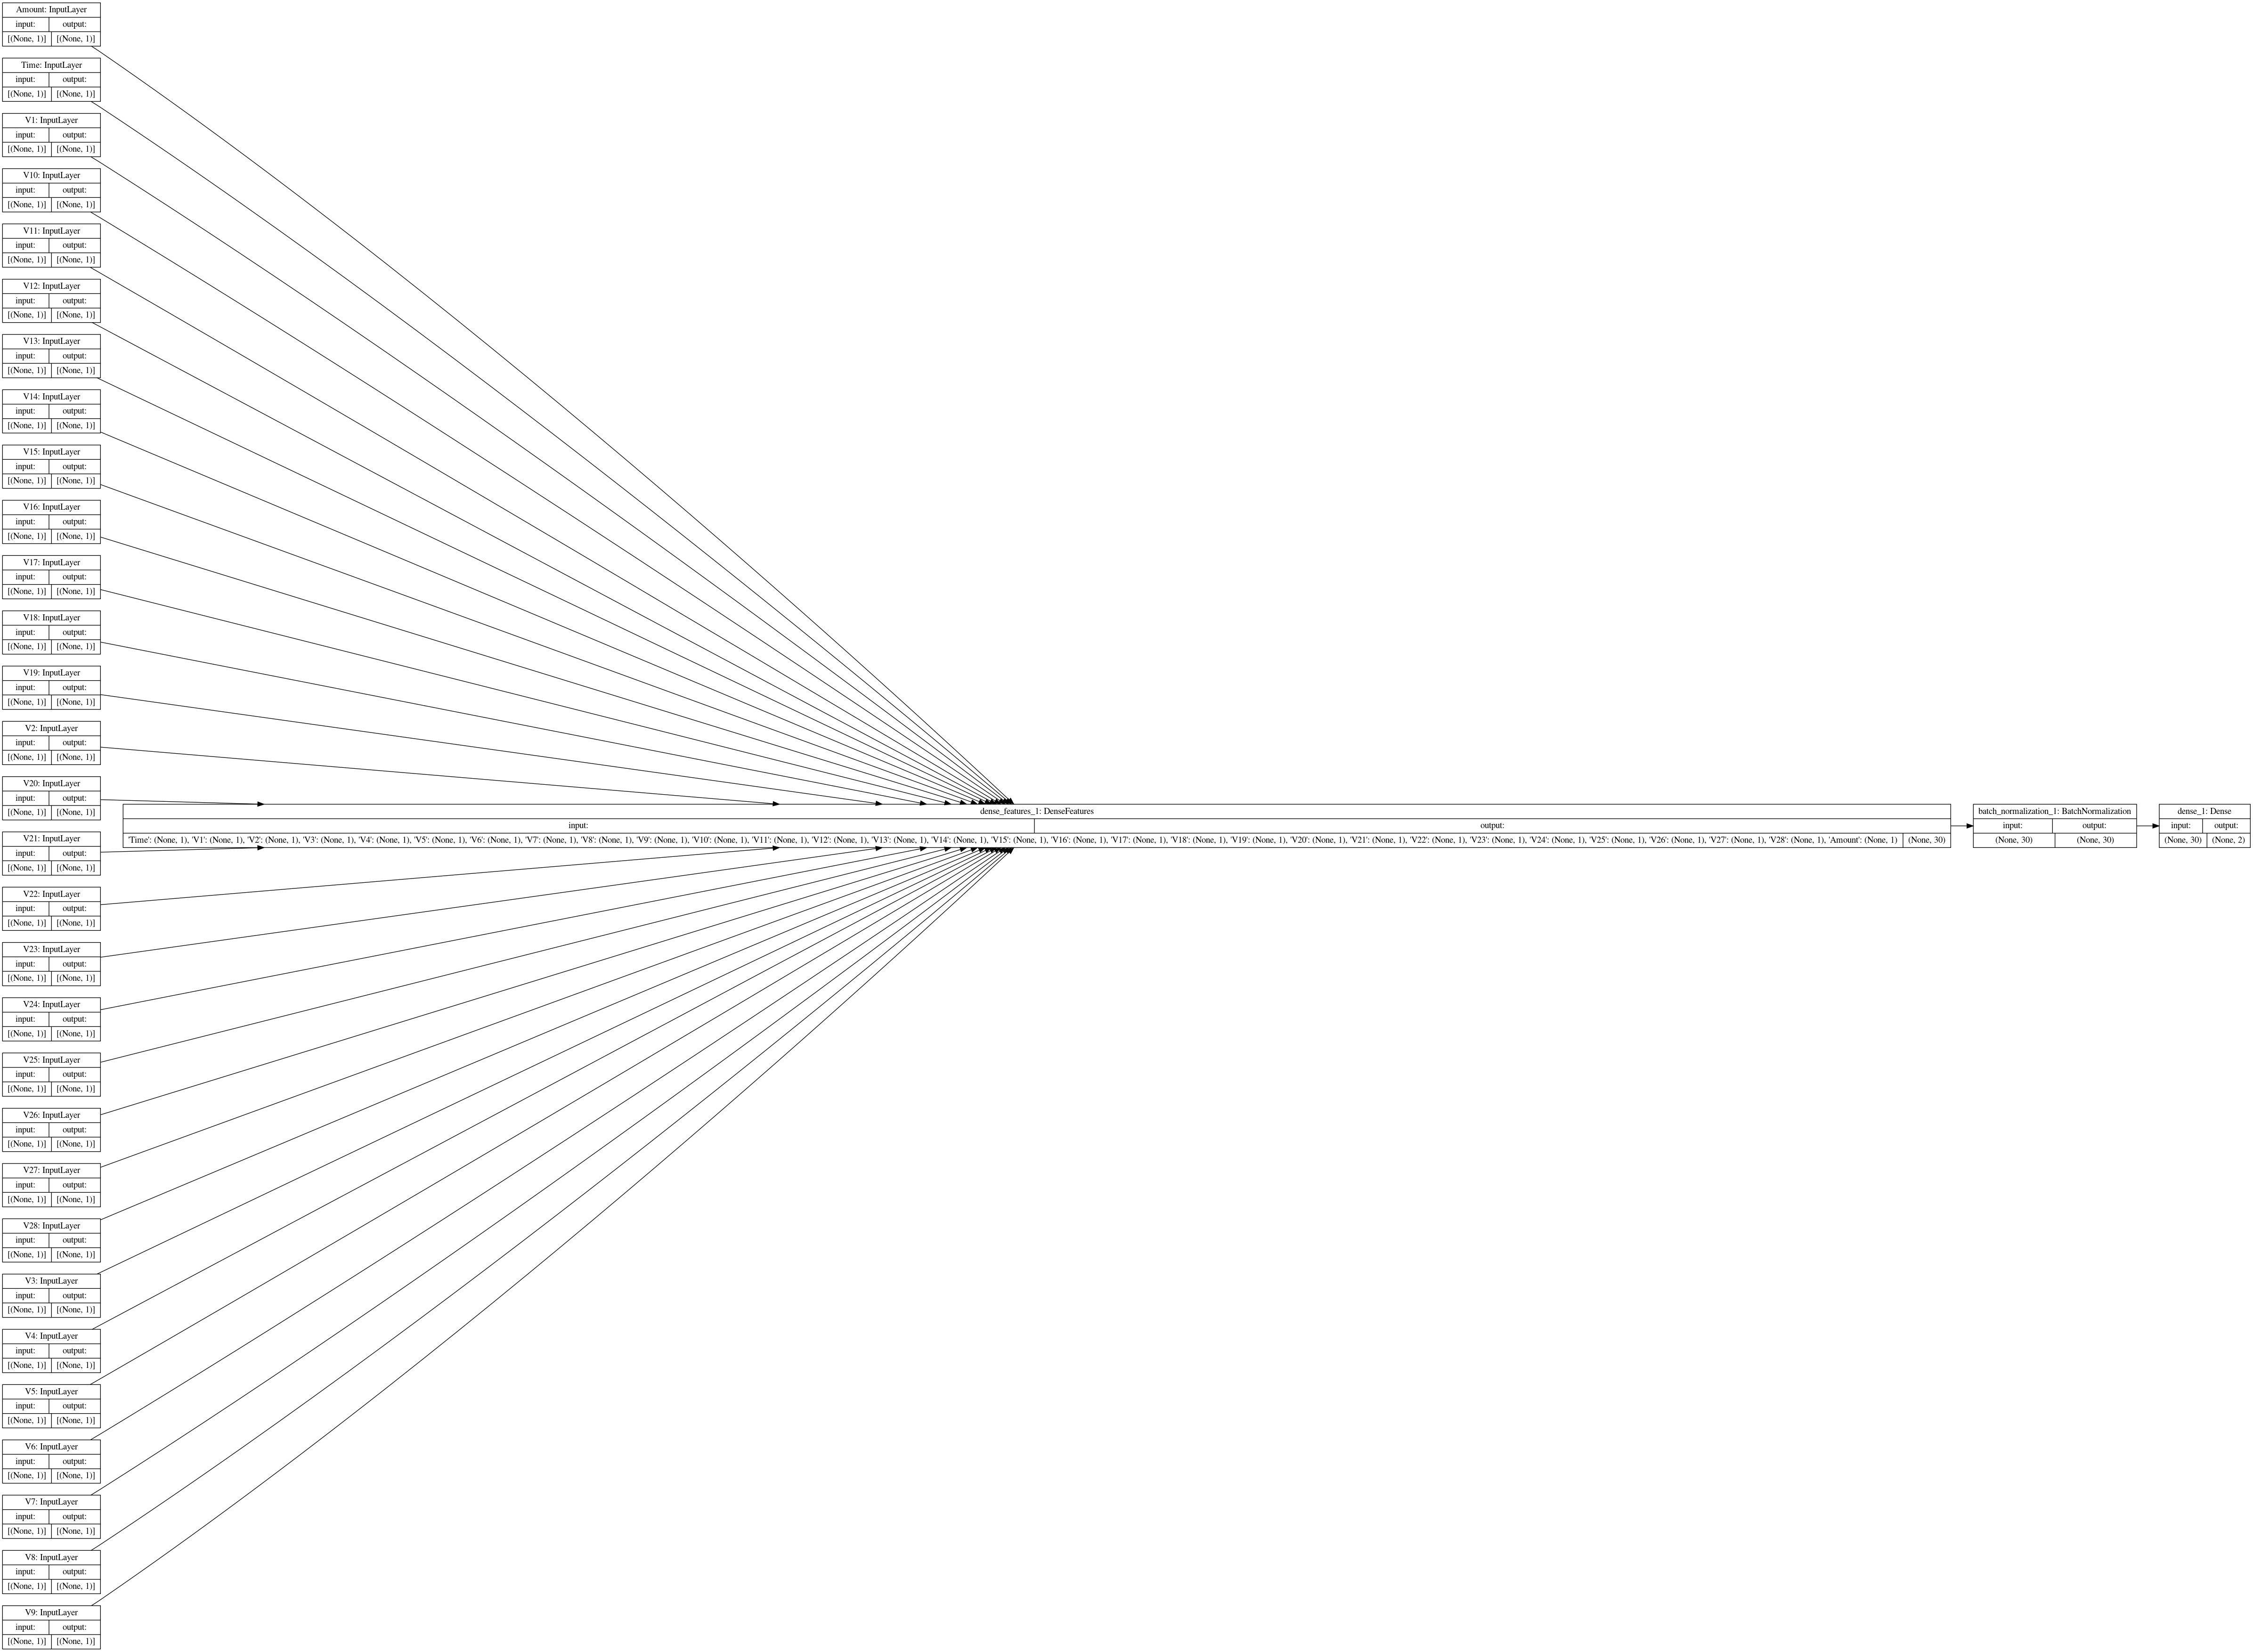

In [71]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [72]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Amount (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Time (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
V1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
V10 (InputLayer)                [(None, 1)]          0                                            
____________________________________________________________________________________________

Fit the Model:

In [73]:
# setup tensorboard logs and train
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = os.path.join(DIR, "logs", datetime.now().strftime("%Y%m%d-%H%M%S")), histogram_freq=1)
history = model.fit(train, epochs = EPOCHS, callbacks = [tensorboard_callback], validation_data = validate)

2022-04-01 01:41:33.584226: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-01 01:41:33.584296: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-01 01:41:33.585571: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10


2022-04-01 01:41:34.662651: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:41:34.662740: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


      3/Unknown - 3s 105ms/step - loss: 0.8968 - accuracy: 0.5200 - auc_1: 0.5653

2022-04-01 01:41:36.183543: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-04-01 01:41:36.183600: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-04-01 01:41:36.301920: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-04-01 01:41:36.310926: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-04-01 01:41:36.324151: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: temp/05/logs/20220401-014133/train/plugins/profile/2022_04_01_01_41_36

2022-04-01 01:41:36.332352: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to temp/05/logs/20220401-014133/train/plugins/profile/2022_04_01_01_41_36/tensorflow-2-7-20220125-120050.trace.json.gz
2022-04-01 01:41:36.341172: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: temp/05/log

   2272/Unknown - 36s 15ms/step - loss: 0.0605 - accuracy: 0.9828 - auc_1: 0.9976

2022-04-01 01:42:10.545458: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:42:10.545540: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 42s 17ms/step - loss: 0.0603 - accuracy: 0.9828 - auc_1: 0.9977 - val_loss: 0.0119 - val_accuracy: 0.9990 - val_auc_1: 0.9992
Epoch 2/10


2022-04-01 01:42:15.902939: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:42:15.903002: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2269/2279 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9992 - auc_1: 0.9994

2022-04-01 01:42:50.629868: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:42:50.629946: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 40s 17ms/step - loss: 0.0082 - accuracy: 0.9992 - auc_1: 0.9994 - val_loss: 0.0088 - val_accuracy: 0.9992 - val_auc_1: 0.9994
Epoch 3/10


2022-04-01 01:42:55.799788: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:42:55.799873: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2277/2279 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9993 - auc_1: 0.9995

2022-04-01 01:43:30.042362: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:43:30.042571: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 39s 17ms/step - loss: 0.0064 - accuracy: 0.9993 - auc_1: 0.9995 - val_loss: 0.0080 - val_accuracy: 0.9992 - val_auc_1: 0.9994
Epoch 4/10


2022-04-01 01:43:34.827365: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:43:34.827433: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2272/2279 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9992 - auc_1: 0.9995

2022-04-01 01:44:09.467028: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:44:09.467119: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 39s 17ms/step - loss: 0.0060 - accuracy: 0.9992 - auc_1: 0.9995 - val_loss: 0.0075 - val_accuracy: 0.9992 - val_auc_1: 0.9994
Epoch 5/10


2022-04-01 01:44:13.947470: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:44:13.947555: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2271/2279 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.9992 - auc_1: 0.9995

2022-04-01 01:44:48.609095: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:44:48.609208: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 43s 19ms/step - loss: 0.0056 - accuracy: 0.9992 - auc_1: 0.9995 - val_loss: 0.0072 - val_accuracy: 0.9992 - val_auc_1: 0.9994
Epoch 6/10


2022-04-01 01:44:56.620383: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:44:56.620469: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2271/2279 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9992 - auc_1: 0.9995

2022-04-01 01:45:31.768133: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:45:31.768225: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 43s 18ms/step - loss: 0.0053 - accuracy: 0.9992 - auc_1: 0.9995 - val_loss: 0.0070 - val_accuracy: 0.9992 - val_auc_1: 0.9994
Epoch 7/10


2022-04-01 01:45:39.437221: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:45:39.437307: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2278/2279 [============================>.] - ETA: 0s - loss: 0.0053 - accuracy: 0.9992 - auc_1: 0.9994

2022-04-01 01:46:16.782119: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:46:16.782206: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 44s 19ms/step - loss: 0.0053 - accuracy: 0.9992 - auc_1: 0.9994 - val_loss: 0.0069 - val_accuracy: 0.9992 - val_auc_1: 0.9994
Epoch 8/10


2022-04-01 01:46:23.615129: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:46:23.615216: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2272/2279 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.9992 - auc_1: 0.9995

2022-04-01 01:47:00.786072: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:47:00.786148: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 43s 18ms/step - loss: 0.0051 - accuracy: 0.9992 - auc_1: 0.9995 - val_loss: 0.0067 - val_accuracy: 0.9992 - val_auc_1: 0.9994
Epoch 9/10


2022-04-01 01:47:06.926976: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:47:06.927058: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2271/2279 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 0.9993 - auc_1: 0.9995

2022-04-01 01:47:42.154437: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:47:42.154520: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 40s 17ms/step - loss: 0.0051 - accuracy: 0.9993 - auc_1: 0.9995 - val_loss: 0.0066 - val_accuracy: 0.9993 - val_auc_1: 0.9994
Epoch 10/10


2022-04-01 01:47:47.380764: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:47:47.380832: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2275/2279 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.9992 - auc_1: 0.9995

2022-04-01 01:48:23.027955: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:48:23.028020: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 41s 18ms/step - loss: 0.0052 - accuracy: 0.9992 - auc_1: 0.9995 - val_loss: 0.0065 - val_accuracy: 0.9993 - val_auc_1: 0.9994


In [74]:
history.history['loss'][-1]

0.005179752130061388

Evaluate the model with the test data:

In [75]:
loss, accuracy, auc = model.evaluate(test)

2022-04-01 01:48:28.755149: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:48:28.755224: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


285/285 [==============================] - 3s 10ms/step - loss: 0.0056 - accuracy: 0.9991 - auc_1: 0.9995


In [76]:
loss, accuracy, auc = model.evaluate(validate)

2022-04-01 01:48:31.933866: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:48:31.933945: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


285/285 [==============================] - 6s 10ms/step - loss: 0.0065 - accuracy: 0.9993 - auc_1: 0.9994


In [77]:
loss, accuracy, auc = model.evaluate(train)

2022-04-01 01:48:37.780419: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:48:37.780539: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


2279/2279 [==============================] - 36s 15ms/step - loss: 0.0070 - accuracy: 0.9992 - auc_1: 0.9993


Create Prediction from a batch of the test data and review first row:

In [78]:
model.predict(test.take(1))[0]

2022-04-01 01:49:19.068251: E tensorflow/core/framework/dataset.cc:552] Unimplemented: Cannot compute input sources for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.
2022-04-01 01:49:19.068321: E tensorflow/core/framework/dataset.cc:556] Unimplemented: Cannot merge options for dataset of type IO>BigQueryDataset, because the dataset does not implement `InputDatasets`.


array([9.9992967e-01, 7.0290182e-05], dtype=float32)

---
## Evaluate The Training With Tensorboard

Visual ML

Resource: https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks

In [79]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [80]:
%tensorboard --logdir $DIR/logs

Reusing TensorBoard on port 6006 (pid 19142), started 2:08:20 ago. (Use '!kill 19142' to kill it.)

---
## Serving

### Save The Model

In [81]:
model.save(URI)

INFO:tensorflow:Assets written to: gs://vertex-ai-mlops-bucket/fraud/models/05/assets
INFO:tensorflow:Assets written to: gs://vertex-ai-mlops-bucket/fraud/models/05/assets


### Upload The Model

In [82]:
model = aiplatform.Model.upload(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    serving_container_image_uri = DEPLOY_IMAGE,
    artifact_uri = URI,
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/825075454589/locations/us-central1/models/4710364987997028352/operations/8820355464261795840
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/825075454589/locations/us-central1/models/4710364987997028352
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/825075454589/locations/us-central1/models/4710364987997028352')


In [41]:
model.display_name

'05_fraud_20220331222728'

### Create An Endpoint

In [42]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/825075454589/locations/us-central1/endpoints/5724189475597189120/operations/1612238707539050496
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/825075454589/locations/us-central1/endpoints/5724189475597189120
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/825075454589/locations/us-central1/endpoints/5724189475597189120')


In [43]:
endpoint.display_name

'05_fraud_20220331222728'

### Deploy Model To Endpoint

In [ ]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1
)

INFO:google.cloud.aiplatform.models:Deploying Model projects/825075454589/locations/us-central1/models/3252043133659119616 to Endpoint : projects/825075454589/locations/us-central1/endpoints/5724189475597189120
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/825075454589/locations/us-central1/endpoints/5724189475597189120/operations/6268960722240143360


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [83]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [84]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,6126,-0.130702,1.026568,2.692793,2.659141,0.764928,1.800330,0.317986,-0.392976,0.851460,...,-0.370958,-1.058635,-0.498915,0.054906,-0.590204,-0.537678,0.0,0,70526fff-bdf3-459f-bbc6-a18e8133bb35,TEST
1,32799,1.153477,-0.047859,1.358363,1.480620,-1.222598,-0.481690,-0.654461,0.128115,0.907095,...,-0.025964,0.701843,0.417245,-0.257691,0.060115,0.035332,0.0,0,e8b3c609-62a9-4ec3-9ff8-fd0974b07602,TEST
2,35599,1.168909,-0.139981,-0.095518,1.735426,1.699903,4.646212,-1.191502,1.205700,0.333882,...,-0.163863,1.045593,0.775343,0.228745,0.050846,0.020019,0.0,0,c5ac2c63-c26b-492e-bc8e-5f98e92ec866,TEST
3,49561,1.333331,-0.845997,1.161578,-0.610965,-1.635783,-0.198304,-1.331531,0.212857,-0.208834,...,-0.095332,0.367347,0.398274,-0.059810,0.041674,0.011653,0.0,0,aca44b9b-e816-4767-b636-0356637c286b,TEST


In [85]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
#newob

In [86]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

### Get Predictions: Python Client

In [93]:
endpoint = aiplatform.Endpoint.list()[0]

In [94]:
prediction = endpoint.predict(instances=instances, parameters=parameters)
prediction

Prediction(predictions=[[0.999432623, 0.000567407114]], deployed_model_id='2382360222413881344', explanations=None)

In [95]:
prediction.predictions[0]

[0.999432623, 0.000567407114]

In [96]:
np.argmax(prediction.predictions[0])

0

### Get Predictions: REST

In [97]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [98]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    [
      0.999432623,
      0.000567407114
    ]
  ],
  "deployedModelId": "2382360222413881344",
  "model": "projects/825075454589/locations/us-central1/models/3252043133659119616",
  "modelDisplayName": "05_fraud_20220331222728"
}


### Get Predictions: gcloud (CLI)

In [99]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[[0.999432623, 0.000567407114]]


---
## Remove Resources
see notebook "99 - Cleanup"